# Bayesian Estimation of Orbital Scaling Parameters


## Introduction 

These notes briefly outline a Bayesian approach to estimating the statistical distribution of the orbital scaling (or $\lambda$) parameters from NIST data and their associated experimental error bars. The atomic structure calculation can be viewed as a mapping $f$ from the true orbital scaling parameter $\lambda \in \mathbb{R}^m$ to a set of observable quantities of interest, $f(\lambda) \in \mathbb{R}^n$. The output of this mapping is measured experimentally, albeit with some error. The simplest "observation model" is to assume that a _random_ error $E = [E_1,...,E_n]\in \mathbb{R}^n$ is added to the output $f(\lambda)$, yielding a _random_ observation

\begin{equation}
Y = f(\lambda) + E.  \tag{1} \label{eqn:observation_model}
\end{equation}

Other observation models are also possible. Now, suppose we don't know the true value of $\lambda$, but that we have a vector  $\vec y_{\text{nist}} = [y_1, y_2, ..., y_n]^T$ of actual NIST measurements of the energies and A-values. Due to the random measurement noise $E$, we cannot be certain that the observed values are the actual outputs $f(\lambda)$. To reflect our uncertainty, we estimate the true $\lambda$ by a random quantity $\Lambda$ whose distribution is consistent with the observations $y_{\text{nist}}$ and the statistical distribution of the error $E$. More specifically, we seek to estimate the conditional density function $\pi_{\Lambda|y_{\text{nist}}}$ given the NIST observations. Bayes formula allows us to express this density in terms of the likelihood $\pi_{Y|\Lambda}$ and a prior density $\pi_\Lambda$: 

\begin{equation}
\pi_{\Lambda|Y}(\lambda|y_{\text{nist}}) = \frac{\pi_\Lambda(\lambda)\pi_{Y|\Lambda}(y_{\text{nist}}|\lambda)}{\pi_{Y}(y_{\text{nist}})}, \tag{2} \label{eqn:bayes_formula}
\end{equation}
provided $\pi_{Y}(y_{\text{nist}})\neq 0$.


### The Likelihood Function

If we have a density function for the measurement noise $\pi_E(e)$, then our given observation model \eqref{eqn:observation_model} makes it easy to determine the likelihood. Indeed, 

$$
\pi_{Y|\Lambda}(y_{\text{nist}}|\lambda)= \mathbb{P}(Y= y_{\text{nist}}|\Lambda=\lambda) = \mathbb{P}(E = y_{\text{nist}}-f(\lambda)) = \pi_E(y_{\text{nist}}-f(\lambda))
$$


#### The Noise Density

We now turn to estimating $\pi_E$. To this end we make the following simplifying assumption - it can be relaxed in principle. 

> _Assumption:_ The measurement errors of the various energies and A-values are statistically independent.

The above assumption allows us to write the joint density function $\pi_{E}$ of the absolute errors $E = [E_1,...,E_n]$ as the product of univariate densities, i.e. 

$$
\pi_{E}(e) = \prod_{i=1}^n \pi_{E_i}(e_i), \ \text{for } e = [e_1,...,e_n] \in \mathbb{R}^n.
$$

Let $\vec \eta = [\eta_1, ..., \eta_n]$ be the relative errors for each quantity of interest, reported in the NIST database. We use these to specify the statistical distribution of the absolute errors.


##### Uniform Errors

If assume that the NIST errors are uniformly distributed, we can use $\eta_i$ to find the range. Specifically, let $a_i = y_i - \eta_i y_i$ and $b_i=y_i + \eta_i y_i$, so that

$$ 
\pi_{E_i}(e_i) = \left\{ 
\begin{array}{ll} 
\frac{1}{b_i-a_i}, & \text{if } a_i \leq e_i \leq b_i \\
0, &\text{otherwise}\end{array} \right. .
$$

The joint distribution is therefore

$$
\pi_{E}(e) = \prod_{i=1}^n \pi_{E_i}(e_i) = \left\{ 
\begin{array}{ll} 
\prod_{i=1}^n \frac{1}{b_i-a_i}, & \text{if } a_i \leq e_i \leq b_i \text{ for } i=1,...,n \\
0, &\text{otherwise}\end{array} \right. .
$$ 

while its logarithm, 

$$
\ln \pi_E(e) = \left\{ \begin{array}{ll} -\sum_{i=1}^n \ln(b_i-a_i), & \text{ if } a_i \leq e_i \leq b_i \text{ for } i=1,...,n \\
-\infty, &\text{otherwise}\end{array} \right. .
$$

##### Gaussian Errors

We can also assume that the NIST errors are Gaussian, in which case $\eta_i$ can be used to determine the standard deviations. Specifically, if we assume that the error range $[y_i-\eta_i y_i, y_i + \eta_i y_i]$ represents a 99.7\% confidence interval (corresponding to 3 standard deviations $\sigma_i$), we can compute $\sigma_i=\frac{2}{3}\eta_iy_i$. The densities are then given by

$$
\pi_{E_i}(e_i) = \frac{1}{\sqrt{2\pi}\sigma_i} \exp\left(-\frac{e_i^2}{2\sigma_i^2}\right).
$$

The joint distribution is

$$
\pi_E(e) = \prod_{i=1}^n \pi_{E_i}(e_i) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi}\sigma_i} \exp\left(-\frac{e_i^2}{2\sigma_i^2}\right) = (2\pi)^{-n/2} \left(\prod_{i=1}^n \frac{1}{\sigma_i}\right) \exp\left(-\frac{1}{2}\sum_{i=1}^n \frac{e_i^2}{\sigma_i^2}\right)
$$

and its logarithm is 

$$
\ln \pi_E(e) = -\frac{n}{2}\ln(2\pi) - \sum_{i=1}^n \ln(\sigma_i) - \frac{1}{2}\sum_{i=1}^n \left(\frac{e_i}{\sigma_i}\right)^2
$$

### The emcee package

Once we have the prior density and the likelihood function, we can use these to generate samples from the posterior density. This is usually achieved by means of a Monte Carlo Markov Chain (MCMC), which generates a random process (a Markov process) whose stationary (long term) distribution equals the desired posterior. The software library [emcee](http://dfm.io/emcee/current/) implements one form of the MCMC algorithm. 

We first import the library:

In [44]:
import emcee
import numpy as np

To test this package, we use a very simple example. Let $\lambda = [\lambda_1, \lambda_2]$ be two input parameters and consider the mapping

$$
f(\lambda) = \left[\begin{array}{c} \lambda_1^2 + \lambda_2^2 \\ \lambda_1 + 3\lambda_2 \end{array} \right].
$$

Here we define the mapping in python. 

In [ ]:
def f(lmd):
    """
    Forward Mapping
    
    Inputs:
    
        lmd: (2,) numpy array [lmd1, lmd2]
        
    Outputs:
    
        flmd: (2,) numpy array [lmd1^2 + lmd2^2, lmd1 + 3lmd2]
    """
    lmd1, lmd2 = lmd
    return np.array([lmd1**2 + lmd2**2, lmd1+3*lmd2])

Let's say the parameter's true value is $\lambda = [1,2]^T$. This results in an output $[5, 7]^T$, which we can use as our measurement. Suppose further that the measurements $Y_1, Y_2$ of the two output quantities of interest have associated errors, $E_i$, $i=1,2$ that are independent and normally distributed with $E_1 \sim N(0, 4)$ and $E_2 \sim N(0,1)$. 

The `emcee` package requires logarithms of density functions as inputs. In our case, we can use the expresion for the Gaussian errors above to show that the likelihood function takes the form

$$
\pi_{Y|\Lambda}(y_{\text{obs}}|\lambda) = -\ln(2\pi) - \ln(4) -\ln(1) - \frac{1}{2} \left(\frac{5-f_1(\lambda)}{16}\right)^2 - \frac{1}{2}\left(\frac{7-f_2(\lambda)}{1}\right)^2
$$

This is how we define the log likelihood in Python.

In [53]:
def ln_likelihood(lmd, y_obs, f):
    """
    Returns the log-likelihood function for the given observations and forward mapping
    
    Inputs:
    
        lmd: (2,) numpy array - input parameter
        
        y_obs: (2, ) numpy array - measurements
        
        f: function, mapping from lambdas to output
        
    Output: double, log(P(y_obs|lmd))
    """
    f1, f2 = f(lmd)
    return -np.log(8*np.pi) - 0.5*( (5-f1)**2/16 + (7-f2)**2/1 )

Let's specify the prior density for $\lambda$. We use a uniform prior for each component, with $\lambda_1 \sim U([0,3])$ and $\lambda_2 \sim U([1.5,2.5])$. The joint log-prior then takes the form

$$
\ln \pi_\Lambda(\lambda) = \left\{ \begin{array}{ll} -\ln(3), & \text{ if } \lambda \in [0,3]\times [1,3]\\
-\infty, & \text{otherwise} \end{array} \right.
$$

In Python it looks like this:

In [63]:
def ln_prior(lmd):
    """
    Compute the log prior density function at a parameter value lmd
    """
    lmd1, lmd2 = lmd
    if 0<=lmd1 and lmd1<=3 and 1.5<=lmd2 and lmd2<=2.5:
        return -np.log(3)
    else:
        return -np.infty
    
#
# Try it out
# 
# Point inside region
lmd = np.array([0.5,2.5])
print(ln_prior(lmd))

# Point outside region
lmd = np.array([-1,2.4])
print(ln_prior(lmd))


-1.09861228867
-inf


Recall that the posterior density is (up to a scaling constant) the product of the prior and the likelihood, so that the log posterior is the sum of their logs

In [64]:
def ln_posterior(lmd, y_obs, f):
    """
    Evaluate the log-posterior density function at a given lmd
    
    Inputs: 
    
        lmd: input variable
        
        y_obs: observed output
        
        f: function, forward mapping
        
    Output:
    
        ln_prior + ln_likelihood
    """
    return ln_prior(lmd) + ln_likelihood(lmd, y_obs, f)

In [78]:
# Specify the dimension of the input space and the number of starting points
n_dim, n_walkers = 2, 100

# Specify starting points for each Markov chain (in a tight ball around optimum)
pos = [np.array([1,2]) + 1e-4*np.random.randn(n_dim) for i in range(n_walkers)]

# Initialize the sampler
sampler = emcee.EnsembleSampler(n_walkers, n_dim, ln_posterior, args=(y_obs, f))

# Run the MCMC routine
sampler.run_mcmc(pos, 1000);

# The sampler.chain has shape (n_walkers, n_steps, n_dim) = (100, 1000, 2)
# Reshape into a (100'000,2) array of samples (but throw away initial sample -> (95'000,2)
samples = sampler.chain[:, 50:, :].reshape((-1, n_dim))

We plot the results using the package ```corner.py```

In [ ]:
import corner

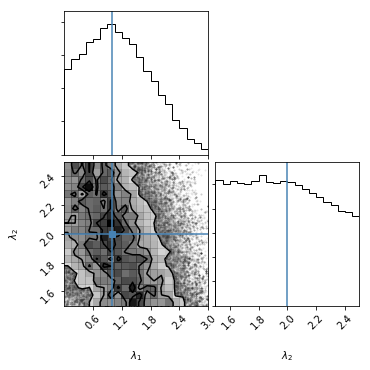

In [80]:
#
# Plot samples
# 
corner.corner(samples, labels=["$\lambda_1$", "$\lambda_2$"], truths=[1, 2])

## O6+

Here we try to estimate the $\lambda$ parameters for OVI+, in particular those corresponding to the 1s, 2s and 2p orbitals, i.e. $\lambda = [\lambda_{1s}, \lambda_{2s}, \lambda_{2p}]$. Our estimation is based on observations of various computable energies and/or A-values. 

### Automating the Structure Calculations

The computation of each observable quantity for a single $\lambda$-value is achieved by means of an R-matrix structure calculation, encoded in the Perl script ```adas803.testern.pl```. Its inputs include, among others, an ```input.dat```  file in which the $\lambda$-values are stored. 

To facilitate the evaluation of multiple such structure calculations corresponding to different $\lambda$-values, we have written a Python class ```LambdaPdf```, contained in the module ```scaling_parameters.py```. This class allows users to 

- Run the structure calculations for a specific the $\lambda$-value, as well as specific observable quantities to be extracted from the ```adf04ic``` output file. 


- Generate a linear interpolant, by running the structure calculations for every $\lambda$-point in a pre-specified grid, recording the resulting quantities of interest, and fitting a piecewise linear function to the data. The interpolant can be used as an approximation for the exact stucture calculation, leading to much faster sampling rates.


- Ultimately, this class is designed to store the statistical distribution of the lambda parameters.


### The NIST Data

The NIST data used for this calibration consists of energies 2-7 (to be found [here](https://physics.nist.gov/cgi-bin/ASD/energy1.pl)) and A-values 2,5, and 7 (to be found [here](https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra=O6&limits_type=0&low_w=&upp_w=&unit=1&submit=Retrieve+Data&de=0&format=0&line_out=0&en_unit=0&output=0&bibrefs=1&page_size=15&show_obs_wl=1&show_calc_wl=1&unc_out=1&order_out=0&max_low_enrg=&show_av=2&max_upp_enrg=&tsb_value=0&min_str=&A_out=0&intens_out=on&max_str=&allowed_out=1&forbid_out=1&min_accur=&min_intens=&conf_out=on&term_out=on&enrg_out=on&J_out=on)). The NIST database entries for the energy levels list no error bounds. In our computations, we make them up by setting them to 'AAA'. 

The NIST error ratings correspond to the following relative errors

| Rating | Relative Error |
| ---| ---|
|'AAA'| 0.003|
|'AA' | 0.01 |
|'A+' | 0.02 |
|'A'  | 0.03 |
|'B+' | 0.07 |
|'B'  | 0.1  |
|'C+' | 0.18 |
|'C'  | 0.25 |
|'D+' | 0.4  |
|'D'  | 0.5  |
|'E'  | 0.5  |

In the code, each quantity of interest is initiated as a ```Qoi``` object, a class that store the NIST values, NIST errors, a search label for locating it in the output file, etc.

> __Example__ Here we initialize the A-value 2. 

In [36]:
#
# Import modules
# 
sys.path.append('../src/')
from scaling_parameters import Qoi, LmdPdf

In [38]:
#
# Initialize Quantity of Interest
# 
a2 = Qoi(category='A-value', tag=2, 
         search_label='   2   1', 
         nist_value=1.04e3, nist_rating='AA')

> __Example:__ We initialize a new $\lambda$-object with one output quantity: ```a2```.

In [41]:
#
# Initialize
#
tags = ['1s', '2s', '2p']  # names 
rng = np.array([[0.8, 1.2], [0.8, 1.2], [0.8, 1.2]])  # lower and upper bounds for each lambda
resolution = (2,2,2)  # resolution of the grid in each direction
path_to_input = '/home/hans-werner/Dropbox/work/projects'+\
                '/atomic_data_uncertainty/code/icft/o_6/'
output_qois = [a2]    
lmd = LmdPdf(tags, rng, resolution, path_to_input, output_qois)

In [17]:
import emcee
import sys
import pickle
import os
import numpy as np

In [54]:
6<10

True

In [27]:
with open('lmd_o6.pickle', 'rb') as f:
    lmd = pickle.load(f)
    
n_qois = len(lmd.qois)
print('Quantities of Interest \n')
for i in range(n_qois):
    print('%s: %d'%(lmd.qois[i].category, lmd.qois[i].tag))

Quantities of Interest 

Energy: 2
Energy: 3
Energy: 4
Energy: 5
Energy: 6
Energy: 7
A-value: 2
A-value: 5
A-value: 7


In [30]:
a = np.array([1,2,3])
a0, a1, a2 = a
print(a0,a1,a2)

1 2 3


In [57]:
np.infty

inf